In [ ]:
!pip install vk_api
!pip install pymorphy2
!pip install emoji

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import preprocessing
matplotlib.style.use('ggplot')
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")
import vk_api
import json
from datetime import datetime
import os
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from string import punctuation, digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import emoji
from wordcloud import WordCloud
%matplotlib inline
from nltk.probability import FreqDist

nltk.download('punkt')
nltk.download('stopwords')
  
from pymorphy2 import MorphAnalyzer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import model_selection
from sklearn.model_selection import learning_curve
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Parsing

In [ ]:
access_token='access_token'
url = 'https://api.vk.com/method/wall.get?domain=natgeoru&count={count}&offset={offset}&access_token={access_token}&v={api_version}'

In [ ]:
def write_parse_data(data):
    with open('geo.csv','a', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow((data['id'],
                         data['dates'],
                         data['times'],
                         data['types'],
                         data['ads'],
                         data['text'],
                         data['likes'],
                         data['comments'],
                         data['reposts'],
                         data['views']))

In [ ]:
count=100
offset=50

for i in range(0, count*150,count):
  url_formatted=url.format(count=count, access_token=access_token, api_version=api_version, offset=offset)
  print(i)
  res_wall=requests.get(url_formatted)
  for post in res_wall.json()['response']['items']:
    id=post['id']
    dates=datetime.fromtimestamp(post['date']).strftime('%d.%m.%Y')
    times=datetime.fromtimestamp(post['date']).strftime('%H:%m') 
    ads=post['marked_as_ads']
    text=post['text']
    likes=post['likes']['count']
    reposts=post['reposts']['count']
    comments=post['comments']['count']
    views=post['views']['count']
    try:
      types=post['attachments'][0]['type']
    except KeyError:
      types=0
    offset+=1
    data={
        'id':id,
        'dates':dates,
        'times':times,
        'types':types,
        'ads':ads,
        'text':text,
        'likes':likes,
        'reposts':reposts,
        'comments':comments,
        'views':views
        }
    write_parse_data(data)

## Data engineering

In [ ]:
df=pd.read_csv('geo.csv', encoding='utf-8', names=['id', 'dates', 'times', 'types',\
                                                   'ads', 'text', 'likes', 'comments',\
                                                   'reposts', 'views'])
df.text=df.text.drop_duplicates()
df=df.dropna()
df.index=range(len(df))
df.tail(10)

,id,dates,times,types,ads,text,likes,comments,reposts,views
14713,1444579,17.07.2019,12:07,link,0,"Вместе они перенесли 50 часов операций, но тол...",126,14,7,26126
14714,1444567,17.07.2019,11:07,link,0,Потрясающая штука появилась в музее Чайковског...,74,3,8,24787
14715,1444555,17.07.2019,10:07,photo,0,Эмоциональный портрет орла от Олега Богданова:...,1742,6,14,35394
14716,1444542,17.07.2019,09:07,link,0,"«Бочки» – одни из крупнейших медуз на свете, н...",242,6,16,29520
14717,1444529,17.07.2019,08:07,link,0,В ряде регионов мира введен запрет на использо...,47,17,1,24065
14718,1444524,17.07.2019,07:07,photo,0,«Поджигая туман» \nАвтор – [id108222227|Андрей...,362,3,8,30258
14719,1444517,17.07.2019,06:07,link,0,При столкновении пуля просто рассыпается на ку...,110,7,8,28375
14720,1444515,17.07.2019,05:07,link,0,Русское географическое общество продлило прием...,19,1,2,21665
14721,1444510,17.07.2019,05:07,photo,0,Рассвет у подножия горы Спящий Саян в природно...,364,0,13,29784
14722,1444493,16.07.2019,19:07,photo,0,«На бульваре Млечного пути»\n\nОбсерватория Те...,720,1,45,38589


In [ ]:
df.shape

(14723, 10)

In [ ]:
df=df.drop('id', axis=1)
df.index=[i for i in range(len(df))]
df.head(5)

,dates,times,types,ads,text,likes,comments,reposts,views
0,24.11.2021,05:11,link,0,Говорила ему мама: «За обезьяной погонишься – ...,141,6,33,15012
1,24.11.2021,04:11,photo,0,Слоны завтракают в приюте Дафны Шелдрика. Посл...,189,1,10,16524
2,23.11.2021,20:11,photo,0,Одиночество рыбака в Челябинской области.\n\nС...,362,9,13,21411
3,23.11.2021,19:11,link,0,Археологи обнаружили в Австралии сразу пять др...,58,0,4,12780
4,23.11.2021,18:11,photo,0,Игуана расслабляется в террариуме. А как вы от...,194,5,11,18525


In [ ]:
def day_of_week(dt):
  day, month, year = (int(x) for x in dt.split('.'))    
  ans = datetime(year, month, day)
  return ans.isoweekday()
def hours(times):
  hours=int(times.split(':')[0])
  return hours

In [ ]:
df['hours'] = 0*(len(df))
df['weekday'] = 0*(len(df))
df['rating'] = 0*(len(df))
df.hours=df.times.apply(hours)
df.weekday=df.dates.apply(day_of_week)
#0 - unpopular
#1 - popular
df.rating[df.likes<np.percentile(df.likes,50)] = 0
df.rating[df.likes>=np.percentile(df.likes,50)] = 1
df.head()

,id,dates,times,types,ads,text,likes,comments,reposts,views,hours,weekday,rating
0,1661455,24.11.2021,05:11,link,0,Говорила ему мама: «За обезьяной погонишься – ...,141,6,33,15012,5,3,0
1,1661453,24.11.2021,04:11,photo,0,Слоны завтракают в приюте Дафны Шелдрика. Посл...,189,1,10,16524,4,3,1
2,1661418,23.11.2021,20:11,photo,0,Одиночество рыбака в Челябинской области.\n\nС...,362,9,13,21411,20,2,1
3,1661415,23.11.2021,19:11,link,0,Археологи обнаружили в Австралии сразу пять др...,58,0,4,12780,19,2,0
4,1661405,23.11.2021,18:11,photo,0,Игуана расслабляется в террариуме. А как вы от...,194,5,11,18525,18,2,1


In [ ]:
df.describe()


,ads,likes,comments,reposts,views,hours,weekday,rating
count,14723.000000,14723.000000,14723.000000,14723.000000,14723.000000,14723.000000,14723.000000,14723.000000
mean,0.004890,326.684439,11.699722,24.343748,26412.448686,12.228961,3.659037,0.500441
std,0.069762,339.773253,17.346320,30.945477,9865.759526,4.438665,1.874191,0.500017
min,0.000000,11.000000,0.000000,0.000000,11619.000000,4.000000,1.000000,0.000000
25%,0.000000,90.000000,3.000000,8.000000,19322.500000,9.000000,2.000000,0.000000
50%,0.000000,163.000000,7.000000,15.000000,24546.000000,12.000000,4.000000,1.000000
75%,0.000000,495.000000,14.000000,29.000000,30372.000000,16.000000,5.000000,1.000000
max,1.000000,3823.000000,634.000000,502.000000,131177.000000,23.000000,7.000000,1.000000


In [ ]:
df=df.drop(['dates', 'times'], axis=1)
df.head(5)

,types,ads,text,likes,comments,reposts,views,hours,weekday,rating
0,link,0,Говорила ему мама: «За обезьяной погонишься – ...,141,6,33,15012,5,3,0
1,photo,0,Слоны завтракают в приюте Дафны Шелдрика. Посл...,189,1,10,16524,4,3,1
2,photo,0,Одиночество рыбака в Челябинской области.\n\nС...,362,9,13,21411,20,2,1
3,link,0,Археологи обнаружили в Австралии сразу пять др...,58,0,4,12780,19,2,0
4,photo,0,Игуана расслабляется в террариуме. А как вы от...,194,5,11,18525,18,2,1


In [ ]:
df.rating.value_counts()

1    7368
0    7355
Name: rating, dtype: int64

In [ ]:
df.types.value_counts()

link     8782
photo    5740
video      76
audio      51
doc        40
0          28
poll        5
event       1
Name: types, dtype: int64

In [ ]:
r={'0':0, 'link':1, 'photo':2,'video':3, 'audio':4, 'doc':5, 'poll':6, 'event':7}
df.types=df.types.map(r)
df.types.value_counts()

1    8782
2    5740
3      76
4      51
5      40
0      28
6       5
7       1
Name: types, dtype: int64

In [ ]:
emojies=dict()
for i in range(len(df)):
  y=df.text[i]
  if emoji.emoji_count(y)>1:
    r=emoji.distinct_emoji_lis(y)
    for j in r:
      s=emoji.demojize(j)
      emojies.update({j:s})
emo=pd.DataFrame(list(emojies.items()), columns=['emoji', 'name'])
emo.to_csv('emojies.csv')

In [ ]:
em=pd.read_excel('/content/drive/MyDrive/Coursework/emojies.xlsx')
em=em.drop('Unnamed: 0', axis=1)
em=em.dropna()
print(em.shape)
em.head()

(410, 3)


,emoji,name,rus
0,📦,:package:,посылка
1,👉🏻,:backhand_index_pointing_right_light_skin_tone:,указатель
2,🦉,:owl:,сова
3,🦜,:parrot:,попугай
4,👏,:clapping_hands:,апплодисменты


In [ ]:
def emojies(text):
  if emoji.emoji_count(text)>0:
    sym=emoji.emoji_lis(text)
    try:
      for k in sym:
        sym1=k['emoji']
        ind=em[em.emoji==sym1].index
        m=em.rus[ind[0]]
        text=text.replace(sym1, m)
    except IndexError:
      h=emoji.demojize(sym1)
      ind=em[em.name==h].index
      m=em.rus[ind[0]]
      text=text.replace(sym1, m)
  return text

In [ ]:
df.text=df.text.apply(emojies)

In [ ]:
morph = MorphAnalyzer()
for i in range(len(df)):
  if i %500==0:
    print(i)
  k=word_tokenize(df.text[i])
  df.text[i]=' '.join([morph.normal_forms(t)[0] for t in k])

In [ ]:
def tokenizer(file_text):
  tokens = without_auth(file_text)
  tokens = re.sub('[^а-яА-ЯёЁ]', ' ', tokens)
  tokens = word_tokenize(tokens)
  tokens = [i for i in tokens if (i not in string.punctuation)] 
  stop_words = stopwords.words('russian')
  stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в','далее',\
                     'который','ещё', 'мочь', 'пока', 'свой', 'ваш','его', 'её',\
                     'мой', 'их', 'наш', 'весь', 'всё', 'среди', 'самый','очень',\
                     'самый', 'сам','однако', 'например', 'просто', 'также',\
                     'тоже', 'каждый', 'сразу', 'своих', 'своим','несколько',\
                     'некоторый', 'лишь', 'около', 'хотя','почему', 'потому',\
                     'смочь', 'фу', 'тук'])
  tokens = [i for i in tokens if (i not in stop_words) and len(i)>2]


  return ' '.join(tokens)

In [ ]:
def without_auth(a):
  t=a
  p=[]
  if ('[' in a) and (']' in a) and ('id' in a) and ('|' in a) and (a.index('[')<a.index('id')<a.index(']')):
    h=word_tokenize(a)
    t=h[:h.index('[')]+h[h.index(']')+1:]
    t=' '.join(t)
  
  if ('[' in a) and (']' in a) and ('club' in a) and ('|' in a) and (a.index('[')<a.index('club')<a.index(']')):
    h=word_tokenize(a)
    t=h[:h.index('[')]+h[h.index(']')+1:]
    t=' '.join(t)
  
  if ('nat-geo.ru/community/user/'in a):
    h=word_tokenize(a)
    pos=[i for i in range(len(h)) if ('nat-geo.ru/community/user/' in h[i])]
    #'name', 'surname','(','https', ':', 'nat-geo.ru/community/user/', ')'
    if (h[pos[0]-1]==':') and (h[pos[0]-2]=='https'):
      t=h[:pos[0]-5]+h[pos[0]+2:]
      t=' '.join(t)
    #'name', 'surname', ':', '(', 'nat-geo.ru/community/user/', ')'
    elif (h[pos[0]-2]==':') and (h[pos[0]-1]=='(')and (h[pos[0]+1]==')'):
      t=h[:pos[0]-4]+h[pos[0]+2:]
      t=' '.join(t)
   #'name', 'surname', '(', 'nat-geo.ru/community/user/', ')'
    elif (h[pos[0]-2]!='https') and (h[pos[0]-2]!=':') and (h[pos[0]-1]=='(') and (h[pos[0]+1]==')'):
      t=h[:pos[0]-3]+h[pos[0]+2:]
      t=' '.join(t)
    #'name', 'surname', ':', 'nat-geo.ru/community/user/', 
    elif (h[pos[0]-2]!='https') and (h[pos[0]-2]!=':') and (h[pos[0]-1]==':'):
      t=h[:pos[0]-3]+h[pos[0]+1:]
      t=' '.join(t)
    
    #'name', 'surname', '-', 'nat-geo.ru/community/user/']
    elif (h[pos[0]-2]!='https') and (h[pos[0]-2]!=':') and (h[pos[0]-1]=='–'):
      t=h[:pos[0]-3]
      t=' '.join(t)
    #'name', 'surname', ',', 'nat-geo.ru/community/user/']
    elif (h[pos[0]-2]!='https') and (h[pos[0]-2]!=':') and (h[pos[0]-1]==','):
      t=h[:pos[0]-3]
      t=' '.join(t)
    #'name', 'surname', 'nat-geo.ru/community/user/', 
    elif (h[pos[0]-2]!='https') and (h[pos[0]-2]!=':') and (h[pos[0]-1]!='(') and (h[pos[0]+1]!=')'):
      t=h[:pos[0]-2]+h[pos[0]+1:]
      t=' '.join(t)
    
  return t

In [ ]:
df.text=df.text.apply(tokenizer)

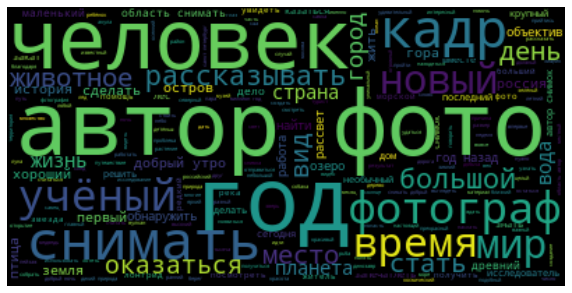

In [ ]:
d=[]
for i in range(len(df)):
    d+=(df.text[i].split(' '))
text=nltk.Text(d)
words_dict = FreqDist(text)
worddict = dict(words_dict)
n_words=len(words_dict.keys())
words=words_dict.keys()
text_raw=" ".join(text)
wordcloud = WordCloud(max_words=2000).generate(text_raw)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
def keyws(text):
  morph=MorphAnalyzer()
  j=text.split()
  u=[worddict[i] if i in worddict else 0 for i in j]
  p=[]
  for k in j:
    mp=morph.parse(k)[0].tag
    if ('NOUN' in mp) or ('VERB' in mp) or ('ADJF' in mp):
      if ('Name' in mp) or ('Surn' in mp) or ('Patr' in mp):
        p.append(0)
      else:
        p.append(1)
    else:
      p.append(0)
  numb=[j for j in range(len(p)) if p[j]==1]
  w=[u[i] for i in numb]
  if len(w)>1:
    maxw=max(w)+1
    w=[f if f>7 else maxw for f in w]
    word=j[numb[w.index(min(w))]]
  elif len(w)==1:
    word=j[u.index(min(w))]
  elif w==[]:
    word=j[u.index(min(u))]
  return word

In [ ]:
morph=MorphAnalyzer()
df['word']=[0]*len(df)
k=[]
for i in range(len(df)):
  y=df.text[i]
  u=[worddict[j] if j in worddict else 0 for j in y.split()]
  j=y.split()
  p=[]
  for k in j:
    mp=morph.parse(k)[0].tag
    if ('NOUN' in mp) or ('VERB' in mp) or ('ADJF' in mp):
      if ('Name' in mp) or ('Surn' in mp) or ('Patr' in mp):
        p.append(0)
      else:
        p.append(1)
    else:
      p.append(0)
  numb=[j for j in range(len(p)) if p[j]==1]
  w=[u[i] for i in numb]
  if len(w)>1:
    maxw=max(w)+1
    w=[f if f>7 else maxw for f in w]
    df.word[i]=y.split()[numb[w.index(min(w))]]
  elif len(w)==1:
    df.word[i]=y.split()[u.index(min(w))]
  elif w==[]:
    df.word[i]=y.split()[u.index(min(u))]
df.head(10)

,types,ads,text,likes,comments,reposts,views,hours,weekday,rating,word
0,1,0,говорить мама обезьяна погнаться дерево застря...,141,6,33,15012,5,3,0,обезьяна
1,2,0,слон завтракать приют дафна шелдрик трапеза ра...,189,1,10,16524,4,3,1,грязь
2,2,0,одиночество рыбак челябинский область снимать,362,9,13,21411,20,2,1,одиночество
3,1,0,археолог обнаружить австралия пять древний бум...,58,0,4,12780,19,2,0,абориген
4,2,0,игуана расслабляться террариум отдыхать вечер ...,194,5,11,18525,18,2,1,игуана
5,1,0,прорыв наука достаточно запостить фото инстагр...,71,2,11,15197,17,2,0,прорыв
6,2,0,союзмультфильм принести детский конкурс рисуно...,75,2,73,13938,16,2,0,пернатое
7,1,0,учёный создать новый модель эволюция магеллано...,74,17,18,13947,15,2,0,мерка
8,1,0,плавать город фантастика прошлое жюля верный р...,75,12,16,14734,15,2,0,прибрежный
9,2,0,словно небо держать солнце ладонь фото,409,1,23,17544,14,2,1,ладонь


In [ ]:
df.to_csv('geo3.csv')

## Data analyses and visualisation

In [ ]:
dt.head()

,types,ads,text,likes,comments,reposts,views,hours,weekday,rating,word
0,1,0,говорить мама обезьяна погнаться дерево застря...,141,6,33,15012,5,3,0,1565
1,2,0,слон завтракать приют дафна шелдрик трапеза ра...,189,1,10,16524,4,3,1,524
2,2,0,одиночество рыбак челябинский область снимать,362,9,13,21411,20,2,1,1613
3,1,0,археолог обнаружить австралия пять древний бум...,58,0,4,12780,19,2,0,0
4,2,0,игуана расслабляться террариум отдыхать вечер ...,194,5,11,18525,18,2,1,829


In [ ]:
df.likes.describe()

count    14723.000000
mean       326.684439
std        339.773253
min         11.000000
25%         90.000000
50%        163.000000
75%        495.000000
max       3823.000000
Name: likes, dtype: float64

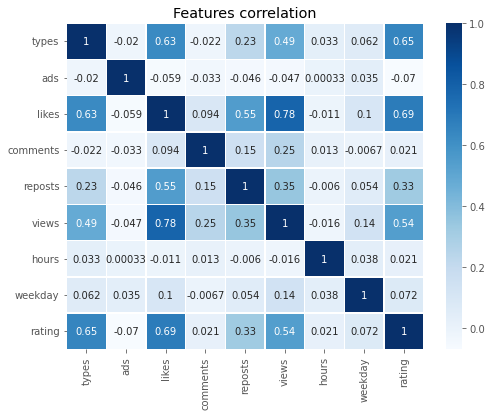

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), annot = True, linewidths=.5, cmap = 'Blues')
ax.set_title('Features correlation')
plt.show()

In [ ]:
cols = df.columns.tolist()
cols.remove('text')
cols.remove('word')

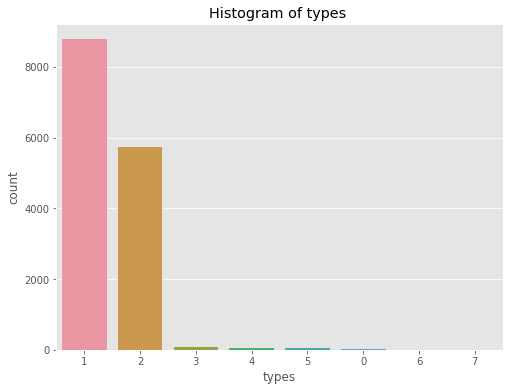

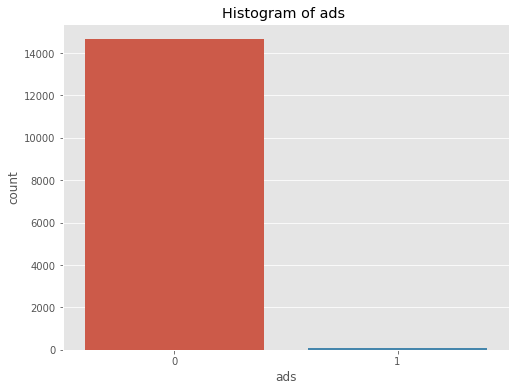

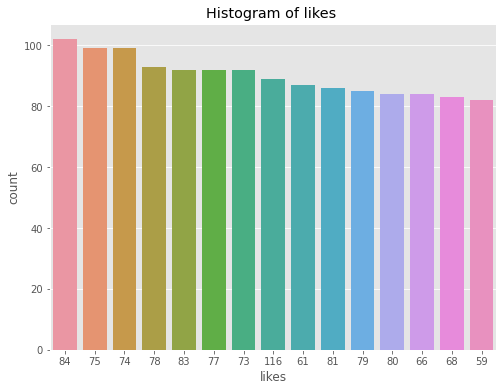

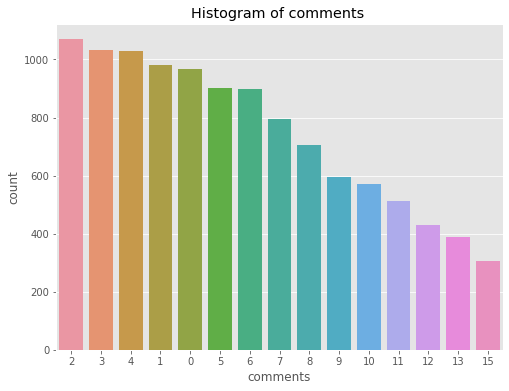

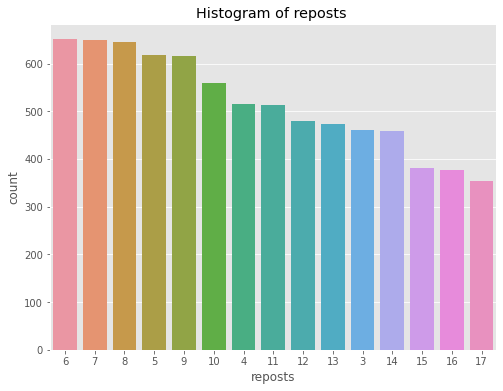

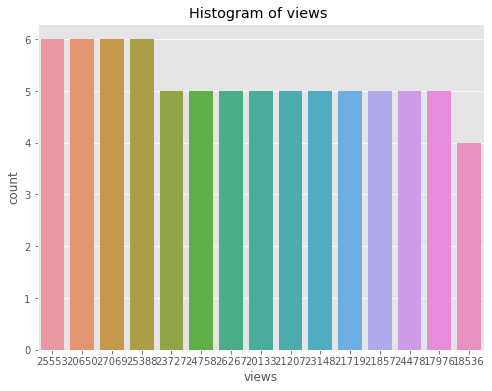

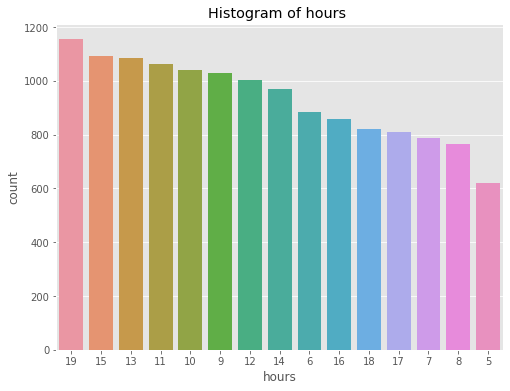

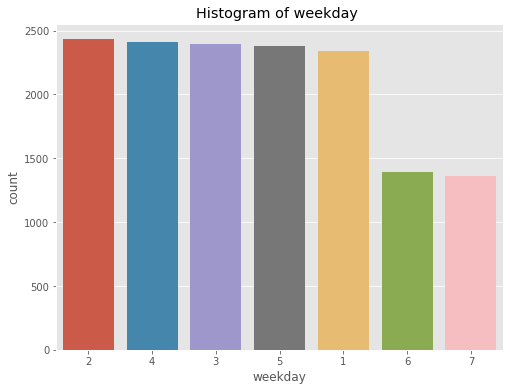

In [ ]:
for column in cols[:-1]:
    columne_most_freq = df[column].value_counts()[:15].sort_values(ascending=False).index
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6))    
    plt.title(f'Histogram of {column} ')
    sns.countplot(
            df[column],
            order=columne_most_freq,
            #palette=colors[column]
            )
    plt.show()

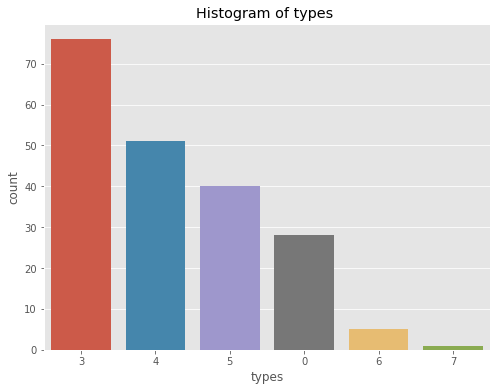

In [ ]:
columne_less_freq = df['types'].value_counts()[2:].sort_values(ascending=False).index
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6))    
plt.title(f'Histogram of types ')
sns.countplot(df['types'],  order=columne_less_freq)
plt.show()

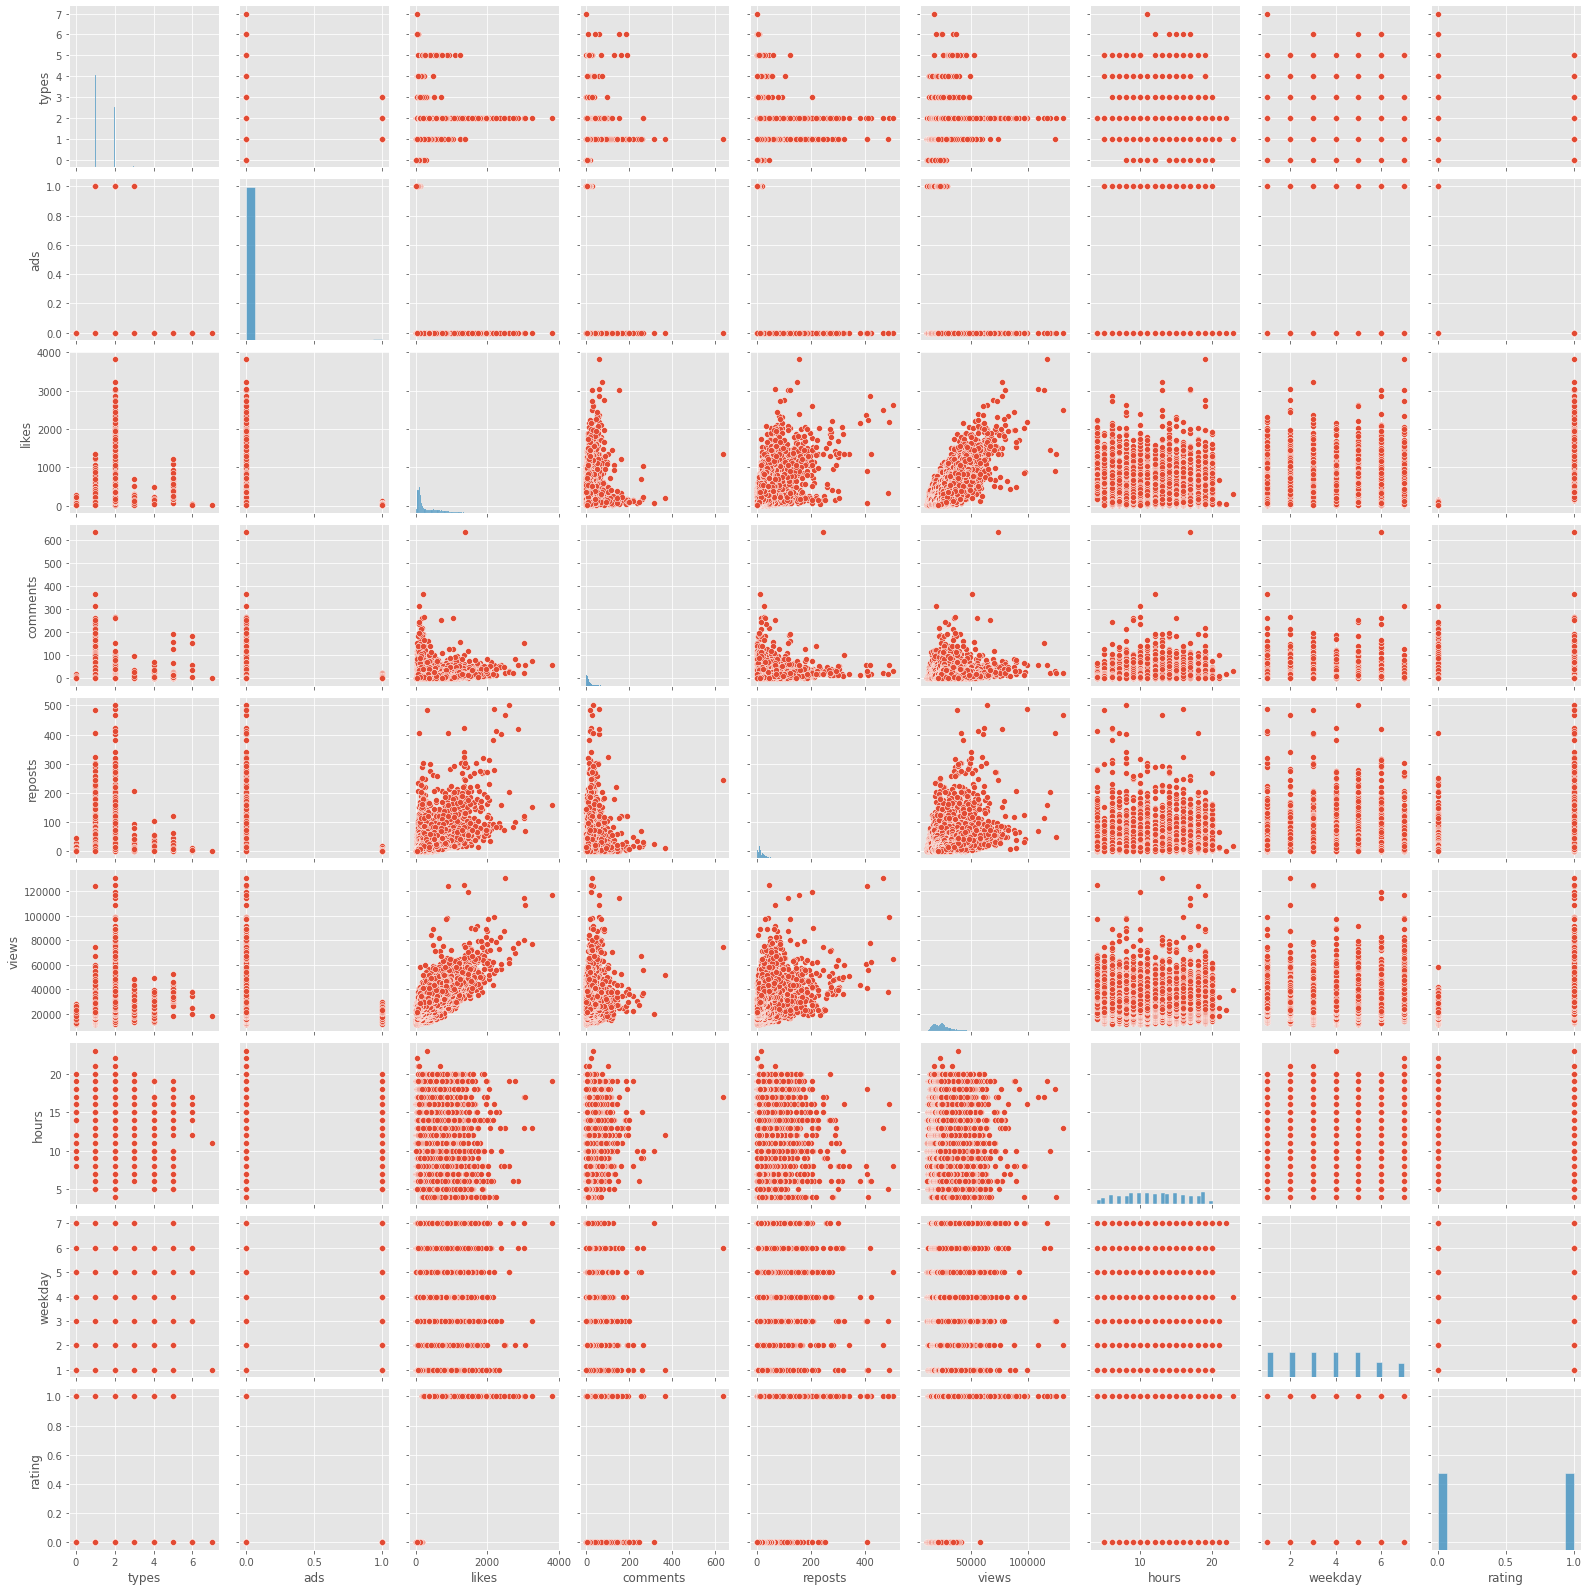

In [ ]:
sns.pairplot(df)

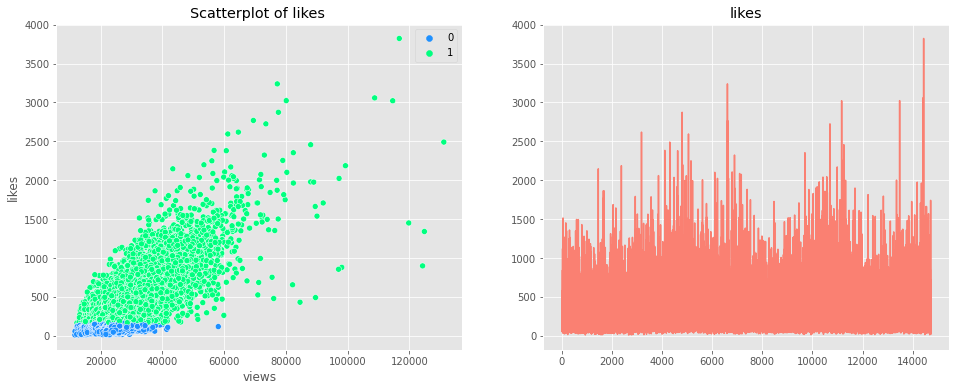

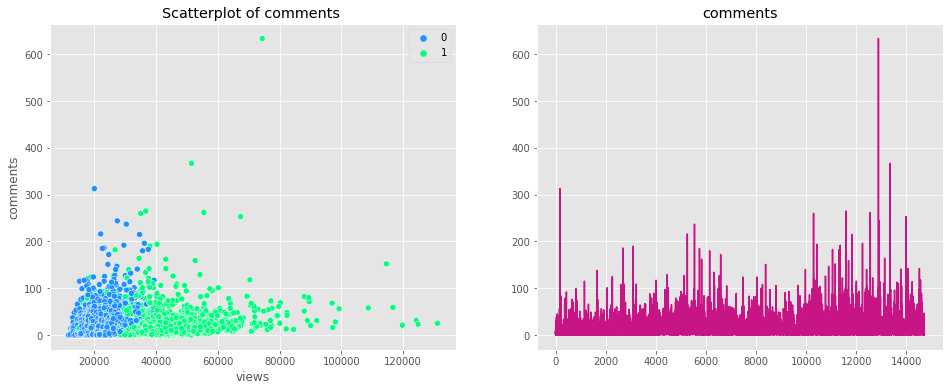

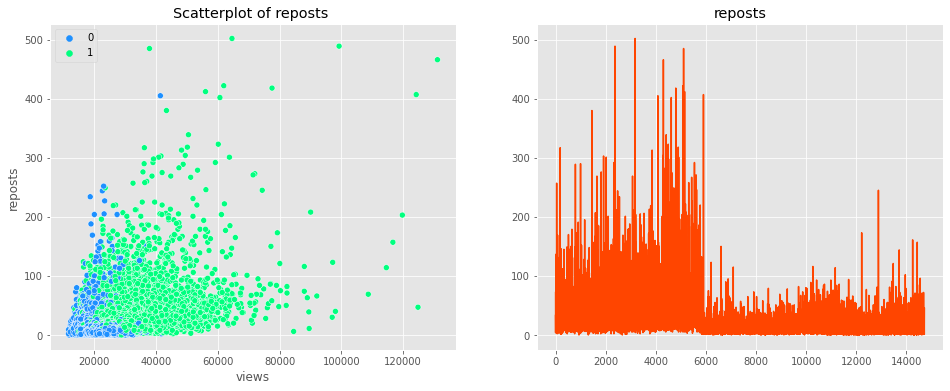

In [ ]:
x=['likes', 'comments', 'reposts']
y='views'
col=['#FA8072', '#C71585', '#FF4500']
for i in x:
  fig, axes = plt.subplots(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.title(f'Scatterplot of {i} ')
  sns.scatterplot(x=y, y=i, data=df, hue='rating', palette=['#1E90FF', '#00FF7F'])
  plt.ylabel(i)
  plt.xlabel(y)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(df[i], c=col[x.index(i)])
  plt.title(i)
  plt.show()

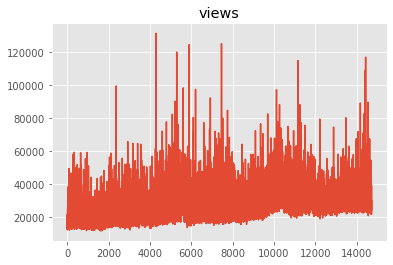

In [ ]:
plt.plot(df['views'])
plt.title('views')
plt.show()

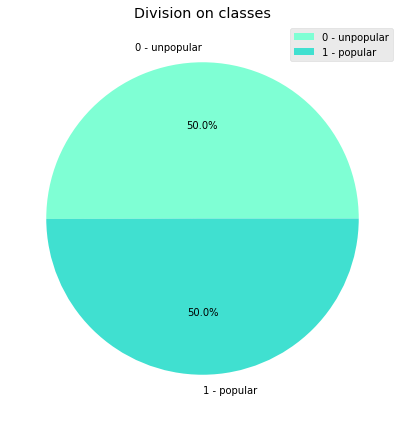

In [ ]:
labels = ['0 - unpopular',
          '1 - popular']
x = list(df.rating.value_counts())
fig1, ax1 = plt.subplots(figsize=(7, 10))
ax1.pie(x, labels=labels,autopct='%1.1f%%', colors=[ '#7FFFD4', '#40E0D0'])
ax1.set_title('Division on classes')
ax1.legend(loc='best')
plt.show()

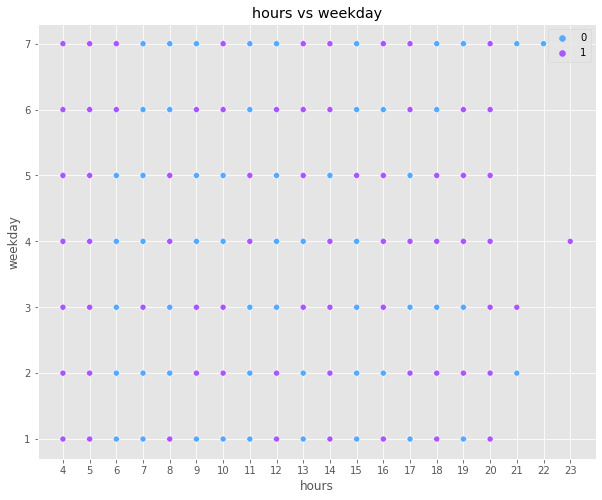

In [ ]:
#cs=['#99ffff','#00FFFF', '#00BFFF', '#1E90FF', '#0000FF', '#4B0082']
x='hours'
y='weekday'
h='rating'
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x = x, y = y, data=df, hue=h, palette='cool')
#ax.set(facecolor = "black")
ax.grid(axis = 'both', color='white')
plt.title(f'{x} vs {y}')
plt.ylabel(y)
plt.xlabel(x)
plt.xticks(list(set(df[x])))
plt.legend()
plt.show()

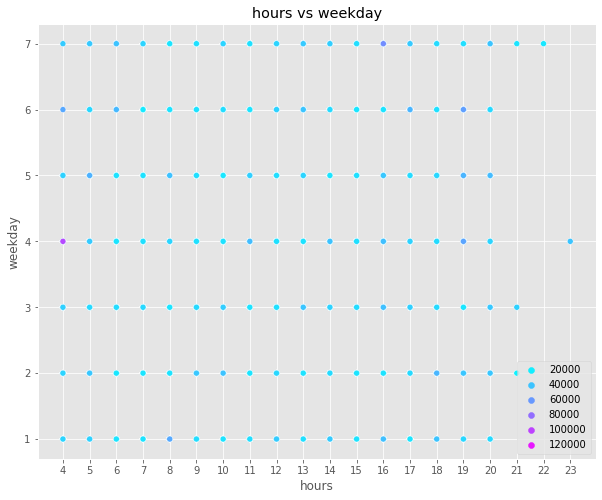

In [ ]:
cs=['#99ffff','#00FFFF', '#00BFFF', '#1E90FF', '#0000FF', '#4B0082']
x='hours'
y='weekday'
h='views'
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x = x, y = y, data=df, hue=h, palette='cool')
#ax.set(facecolor = "black")
ax.grid(axis = 'both', color='white')
plt.title(f'{x} vs {y}')
plt.ylabel(y)
plt.xlabel(x)
plt.xticks(list(set(df.hours)))
plt.legend()
plt.show()

## Models

In [ ]:
dt=pd.read_csv('geo3.csv')
dt=dt.drop('Unnamed: 0', axis=1)
dt=dt.dropna()
dt.index=range(len(dt))
dt.head(5)
dt.shape

(14723, 11)

In [ ]:
dt.tail(10)

,types,ads,text,likes,comments,reposts,views,hours,weekday,rating,word
14713,1,0,вместе перенести час операция увидеть друг дру...,126,14,7,26126,12,3,0,операция
14714,1,0,потрясать штука появиться музей чайковский кли...,74,3,8,24787,11,3,0,мелодия
14715,2,0,эмоциональный портрет орёл,1742,6,14,35394,10,3,1,эмоциональный
14716,1,0,бочка крупный медуза свет особь феноменальный ...,242,6,16,29520,9,3,1,бочка
14717,1,0,ряд регион мир ввести запрет использование пла...,47,17,1,24065,8,3,0,трубочка
14718,2,0,поджигать туман автор снятой киров,362,3,8,30258,7,3,1,снятой
14719,1,0,столкновение пуля рассыпаться кусочек дело пуз...,110,7,8,28375,6,3,0,столкновение
14720,1,0,русский географический общество продлить приём...,19,1,2,21665,5,3,0,заявка
14721,2,0,рассвет подножие гора спать саяна природный па...,364,0,13,29784,5,3,1,ергак
14722,2,0,бульвар млечный путь обсерватория тейде тенери...,720,1,45,38589,19,2,1,обсерватория


In [ ]:
morph=MorphAnalyzer()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(dt.word)
dt.word=le.transform(dt.word)


In [ ]:
dt.head()

In [ ]:
X = dt.drop(['likes','text','rating', 'reposts', 'views', 'comments'], axis=1)
ylikes= dt.likes
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X, ylikes,  test_size = 0.2)

Xf = dt.drop(['likes','text','rating'],axis=1)
X_trainf, X_testf, y_trainf, y_testf = train_test_split(Xf, ylikes,  test_size = 0.2)

In [ ]:
X1 = dt.text
y1= dt.rating
cv=CountVectorizer()
cv.fit(X1)
X1=cv.transform(X1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,  test_size = 0.2)

In [ ]:
%%time
modcl=MultinomialNB(alpha=3)
modcl.fit(X_train1, y_train1)
pred1=modcl.predict(X_test1)
print('Classification report:','\n', classification_report(y_test1, pred1))
print('Confusion matrix:','\n',confusion_matrix(y_test1, pred1))
print('Accuracy score: {:3f}'.format(accuracy_score(y_test1, pred1)))
print('\n')

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      1471
           1       0.92      0.79      0.85      1474

    accuracy                           0.86      2945
   macro avg       0.87      0.86      0.86      2945
weighted avg       0.87      0.86      0.86      2945

Confusion matrix: 
 [[1375   96]
 [ 313 1161]]
Accuracy score: 0.861121


CPU times: user 22.3 ms, sys: 1.96 ms, total: 24.3 ms
Wall time: 24.7 ms


In [ ]:
%%time
model=GradientBoostingRegressor()
modl=model.fit(X_train_l, y_train_l)
predl=modl.predict(X_test_l)
r2l=r2_score(y_test_l, predl)

model=GradientBoostingRegressor()
modf=model.fit(X_trainf, y_trainf)
predf=modf.predict(X_testf)
r2f=r2_score(y_testf, predf)


col=['not', 'full']
res=[r2l, r2f]
tab=pd.DataFrame(zip(col, res), columns=['column', 'R2'])
print(tab)

  column        R2
0    not  0.591019
1   full  0.890207
CPU times: user 2.18 s, sys: 6.74 ms, total: 2.19 s
Wall time: 2.18 s


In [ ]:
tab

,column,R2
0,not,0.591019
1,full,0.890207


## Forecasts


In [ ]:
access_token='access_token'
url = 'https://api.vk.com/method/wall.get?domain=natgeoru&count={count}&offset={offset}&access_token={access_token}&v={api_version}'
api_version=5.131

In [ ]:
def write_parse_data2(data):
    with open('geo4.csv','w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow((data['id'],
                         data['dates'],
                         data['times'],
                         data['types'],
                         data['ads'],
                         data['text'],
                         data['likes'],
                         data['comments'],
                         data['reposts'],
                         data['views']))

In [ ]:
count = 1
offset = 112

for i in range(0, count*1,count):
  url_formatted = url.format(count=count, access_token=access_token, api_version=api_version, offset=offset)
  print(i)
  res_wall = requests.get(url_formatted)
  for post in res_wall.json()['response']['items']:
    id = post['id']
    dates = datetime.fromtimestamp(post['date']).strftime('%d.%m.%Y')
    times = datetime.fromtimestamp(post['date']).strftime('%H:%m') 
    ads = post['marked_as_ads']
    text = post['text']
    likes = post['likes']['count']
    reposts = post['reposts']['count']
    comments = post['comments']['count']
    views = post['views']['count']
    try:
      types = post['attachments'][0]['type']
    except KeyError:
      types = 0
    offset+=1
    data = {
        'id':id,
        'dates':dates,
        'times':times,
        'types':types,
        'ads':ads,
        'text':text,
        'likes':likes,
        'reposts':reposts,
        'comments':comments,
        'views':views
        }
    print(data)
    write_parse_data2(data)

0
{'id': 1665486, 'dates': '13.12.2021', 'times': '10:12', 'types': 'photo', 'ads': 0, 'text': 'В таком освещении Колокольня Никольского собора напоминает волшебную башню из сказок. Фото — Андрей Баскевич: nat-geo.ru/community/user/203988/', 'likes': 427, 'reposts': 34, 'comments': 12, 'views': 17343}


In [ ]:
da=pd.read_csv('geo4.csv', encoding='utf-8', names=['id', 'dates', 'times', 'types',\
                                                   'ads', 'text', 'likes', 'comments',\
                                                   'reposts', 'views'])

da

,id,dates,times,types,ads,text,likes,comments,reposts,views
0,1665486,13.12.2021,10:12,photo,0,В таком освещении Колокольня Никольского собор...,427,12,34,17343


In [ ]:
morph = MorphAnalyzer()
k = word_tokenize(da.text[0])
da.text[0] = ' '.join([morph.normal_forms(t)[0] for t in k])
da.text[0] = tokenizer(da.text[0])
da['hours'] = da.times.apply(hours)
da['weekday'] = da.dates.apply(day_of_week)
da['rating'] = [1 if i>=np.mean(dt.likes) else 0 for i in da.likes]
da['types'] = da.types.map(r)
da['word'] = da.text.apply(keyws)
da = da.drop(['id', 'dates','times'], axis=1)
da

,types,ads,text,likes,comments,reposts,views,hours,weekday,rating,word
0,2,0,освещение колокольня никольский собор напомина...,427,12,34,17343,10,1,1,освещение


In [ ]:
predcl=da.text
predcl=cv.transform(predcl)
predreg=da.drop(['likes','text','reposts','views', 'comments', 'rating'], axis=1)
predregf=da.drop(['likes', 'text', 'rating'], axis=1)
try:
  predregf.word=le.transform(predregf.word)
  predreg.word=le.transform(predreg.word)
except KeyError and ValueError:
  predregf.word=0
  predreg.word=0
predregf

,types,ads,comments,reposts,views,hours,weekday,word
0,2,0,12,34,17343,10,1,1672


In [ ]:
ypredcl=modcl.predict(predcl)
ypredreg=modl.predict(predreg)
ypredregf=modf.predict(predregf)

names=['predicted', 'real']
preds=[ypredcl[0], ypredreg[0], ypredregf[0]]
real=[da.rating[0], da.likes[0], da.likes[0]]
indexes=['rating', 'likes', 'likes with all params']
resl=pd.DataFrame(zip(preds,real), columns=names, index=indexes)
resl

,predicted,real
rating,1.000000,1
likes,565.571757,427
likes with all params,408.732968,427
